In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as stattools
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import math

In [2]:
# Import for cointegration
from arch.unitroot.cointegration import engle_granger

In [3]:
df = pd.read_csv("../prices.txt", sep='\s+', header=None, index_col=None)
df.rename(columns=lambda c: str(c), inplace=True)
df["time"] = pd.to_datetime([i for i in range(1000)], unit='D', origin=pd.Timestamp('2020-01-01'))
df.set_index("time", inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,13.46,71.65,48.46,50.52,52.10,13.00,18.98,47.71,69.49,49.96,...,32.64,55.76,14.46,58.94,36.71,52.62,49.33,36.22,49.00,56.09
2020-01-02,13.48,72.10,48.52,50.50,52.06,12.95,18.95,47.84,69.73,49.93,...,32.52,55.97,14.44,59.81,36.64,52.58,49.20,36.27,48.84,56.08
2020-01-03,13.47,72.35,48.48,50.62,51.80,12.79,18.98,47.98,69.60,49.33,...,32.48,56.34,14.50,59.04,36.89,52.49,49.48,36.39,48.56,55.90
2020-01-04,13.53,72.51,48.42,50.75,51.66,12.66,18.96,48.74,69.54,49.67,...,32.59,56.32,14.40,58.73,36.94,52.40,49.42,36.41,49.00,56.14
2020-01-05,13.64,71.99,48.40,50.65,51.97,12.62,18.89,48.88,69.68,49.46,...,32.64,56.32,14.36,59.01,37.03,52.44,49.79,36.42,48.14,55.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-22,9.27,65.97,43.94,42.04,48.28,6.48,16.28,58.53,67.89,61.94,...,26.88,83.18,9.25,45.49,29.51,44.26,78.38,34.09,45.80,53.36
2022-09-23,9.16,66.02,43.92,42.08,47.76,6.45,16.31,58.85,67.83,62.64,...,26.85,83.49,9.27,45.70,29.51,44.35,78.01,34.00,46.00,53.38
2022-09-24,9.12,65.64,43.93,42.19,47.78,6.45,16.32,58.63,67.83,63.37,...,26.80,83.66,9.27,45.63,29.53,44.35,78.07,33.80,45.89,53.02


In [4]:
preTrain = df[:750][:]
preTest = df[750:1000][:]

In [5]:
# df = np.log(df)
# train = np.log(preTrain)
# test = np.log(preTest)

train = preTrain
test = preTest

In [6]:
print(df["14"].describe())
print(df["16"].describe())
print(df["24"].describe())
print(df["49"].describe())

count    1000.000000
mean       13.582610
std         1.429092
min        10.710000
25%        12.632500
50%        13.380000
75%        14.740000
max        16.980000
Name: 14, dtype: float64
count    1000.000000
mean       34.175850
std         1.216804
min        31.990000
25%        33.110000
50%        34.320000
75%        35.200000
max        36.240000
Name: 16, dtype: float64
count    1000.000000
mean       60.648690
std         2.852694
min        56.060000
25%        57.560000
50%        60.870000
75%        63.360000
max        64.970000
Name: 24, dtype: float64
count    1000.000000
mean       54.836260
std         1.667924
min        51.500000
25%        53.465000
50%        54.640000
75%        56.110000
max        59.310000
Name: 49, dtype: float64


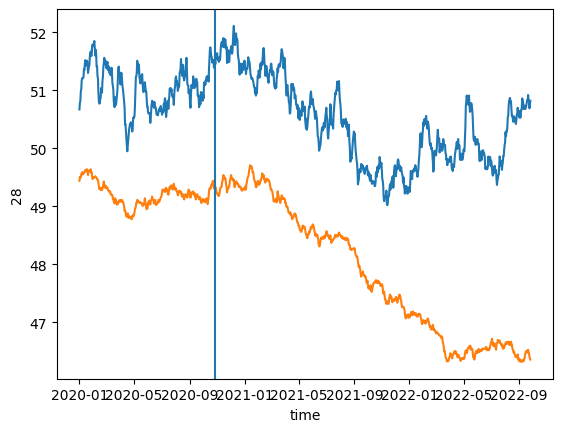

In [7]:
sns.lineplot(df["28"])
sns.lineplot(df["39"])
plt.axvline(x = pd.to_datetime([300], unit='D', origin=pd.Timestamp('2020-01-01')))
plt.savefig("check.png")

In [8]:
# Check if stationary
# Non-stationary
def test_stationary(series, printing=False, threshold=0.07):
    dftest = stattools.adfuller(series, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    if printing:
        print("Results of Dickey-Fuller Test:")
        print(dfoutput)

    
    kpsstest = stattools.kpss(series, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    if printing:
        print("Results of KPSS Test:")
        print(kpss_output)
    
    isStationary = dfoutput["p-value"] < threshold or kpss_output["p-value"] > threshold
    if printing:
        print("STATIONARY: ", isStationary)    

    return (dfoutput["p-value"], kpss_output["p-value"], isStationary)

In [9]:
# Find cointegrated pair with statsmodel
threshold = 0.05

coint_pairs = []
train_coint_matrix = [[-1] * 50 for i in range(50)]
test_coint_matrix = [[-1] * 50 for i in range(50)]
for i in range(50):
    for j in range(i+1, 50):
        train_coint_pVal = stattools.coint(train[str(i)], train[str(j)])[1]
        test_coint_pVal = stattools.coint(test[str(i)], test[str(j)])[1]
        train_coint_matrix[i][j] = train_coint_pVal
        test_coint_matrix[i][j] = test_coint_pVal

        if (train_coint_pVal < threshold and test_coint_pVal < threshold):
            coint_pairs.append((i, j))

print(coint_pairs)


[(7, 28), (8, 46), (14, 36), (20, 25), (20, 35)]


In [10]:
# Get the cointegration vectors with engle_granger
threshold = 0.1
coint_vecs = {}
pairs = []
for i in range(50):
    for j in range(i+1, 50):
        pair = (i, j)
        result = engle_granger(train[str(pair[0])], train[str(pair[1])], trend='c', method='bic')
        testTest = engle_granger(test[str(pair[0])], test[str(pair[1])], trend='c', method='bic')
        fullTest = engle_granger(df[str(pair[0])], df[str(pair[1])], trend='c', method='bic')
        if result.pvalue < threshold and (testTest.pvalue < threshold and fullTest.pvalue < threshold):
            coint_vecs[pair] = result.cointegrating_vector[:2]
            print(pair, result.pvalue, testTest.pvalue)
            print(result.cointegrating_vector)
            pairs.append(pair)

(4, 5) 0.0770178948010063 0.028517218597592597
4         1.000000
5        -0.777715
const   -46.336721
dtype: float64
(7, 49) 0.049221787371327125 0.0781711461272674
7          1.000000
49         1.214857
const   -115.452027
dtype: float64
(14, 18) 0.004559374278398034 0.08406572855398214
14       1.000000
18      -0.857837
const   -3.004548
dtype: float64
(14, 29) 0.00564637859762656 0.06652478586657953
14       1.000000
29      -0.663623
const    5.952328
dtype: float64
(14, 32) 0.07079150477997281 0.09674706851469866
14       1.000000
32      -0.280776
const    0.622599
dtype: float64
(14, 34) 0.031464787727435224 0.09312660141808687
14       1.000000
34      -0.425954
const   -4.058733
dtype: float64
(14, 40) 0.08962991908302609 0.09437350682651996
14       1.000000
40      -0.744571
const    8.931810
dtype: float64
(20, 25) 0.05044066879117777 0.015756991692734795
20        1.000000
25       -0.467178
const   -38.788655
dtype: float64
(20, 35) 0.01621605952075757 0.0334180310975

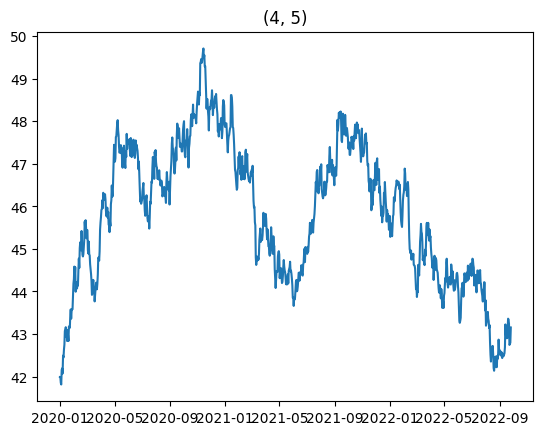

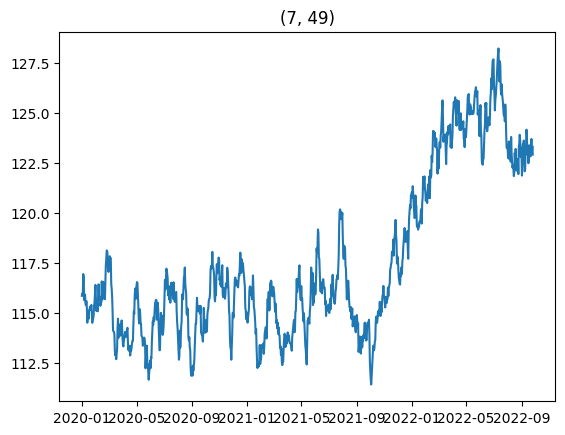

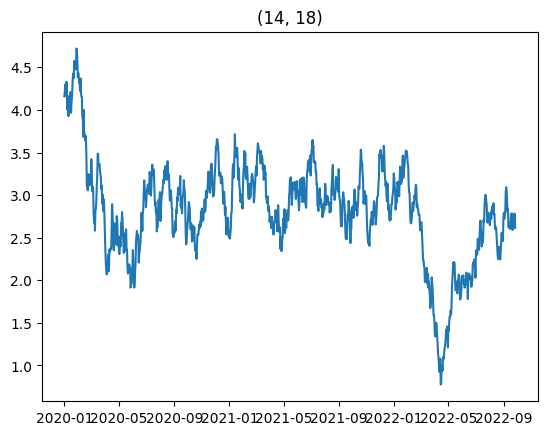

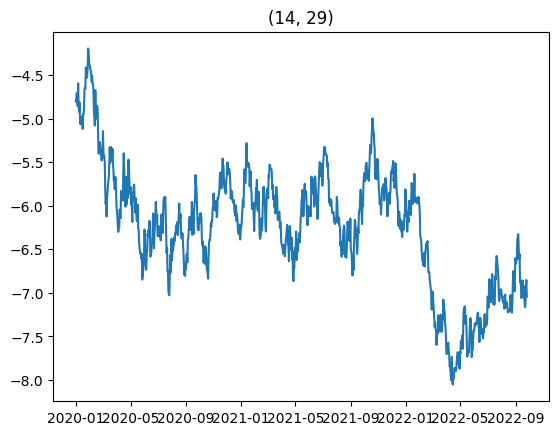

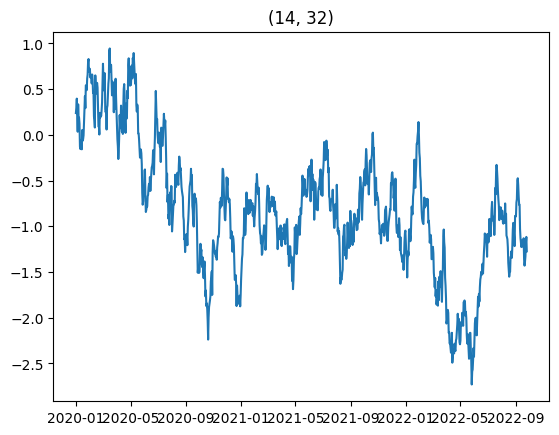

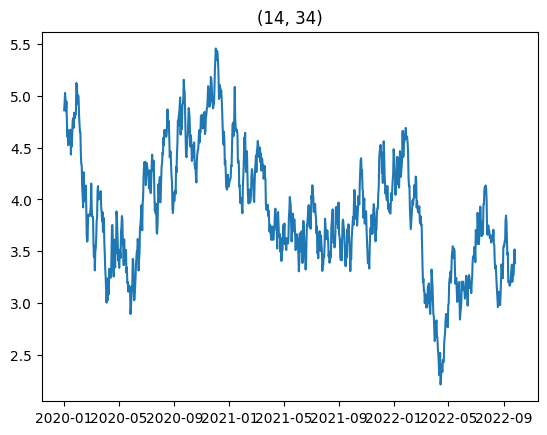

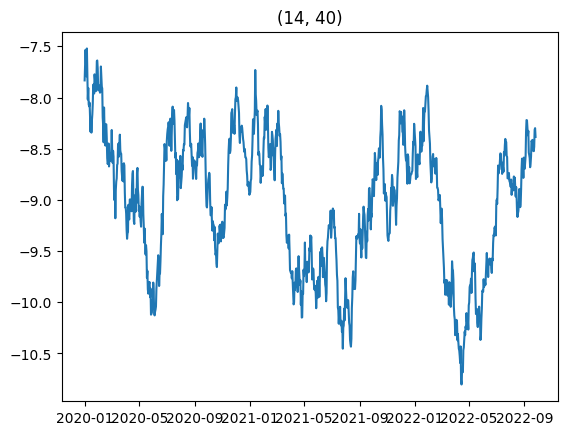

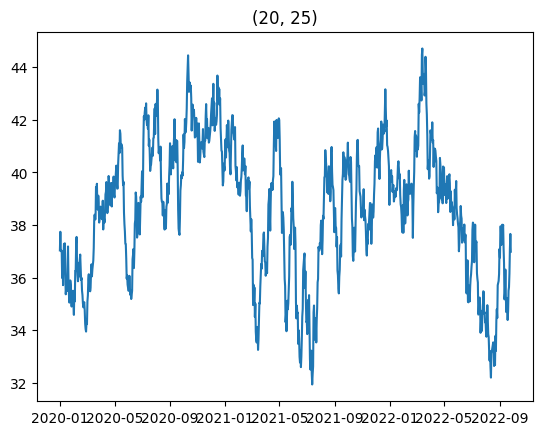

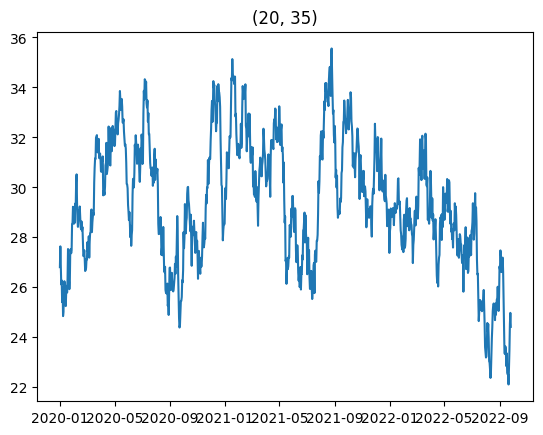

In [11]:
# [('33', '35', -7.91, 1.49, 1.0, -0.66, 0.5),
# ('20', '24', -24.39, 1.29, 1.0, -1.57, 0.7),
# ('7', '26', 77.11, 1.07, 1.0, 0.35, 1.1),
# ('10', '18', -8.52, 0.78, 1.0, -4.01, 1.3),
# ('21', '42', 4.83, 0.24, 1.0, -1.49, 1.0),
# ('4', '5', 29.7, 0.61, 1.0, -2.8, 1.0),
# ('14', '39', -76.8, 0.28, 1.0, -1.9, 1.9)]

for pair in pairs:
    t1, t2 = pair
    betas = coint_vecs[pair].values
    plt.figure()
    plt.title(pair)
    plt.plot(df[str(t1)] * betas[0] + df[str(t2)] * betas[1])

-0.0007883279433165383 -35.4266751500982
Results of Dickey-Fuller Test:
Test Statistic                  -5.427035
p-value                          0.000003
#Lags Used                       0.000000
Number of Observations Used    999.000000
Critical Value (1%)             -3.436913
Critical Value (5%)             -2.864437
Critical Value (10%)            -2.568313
dtype: float64
Results of KPSS Test:
Test Statistic            0.451742
p-value                   0.054853
Lags Used                18.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64
STATIONARY:  True


(2.97135253029776e-06, 0.05485276744125926, True)

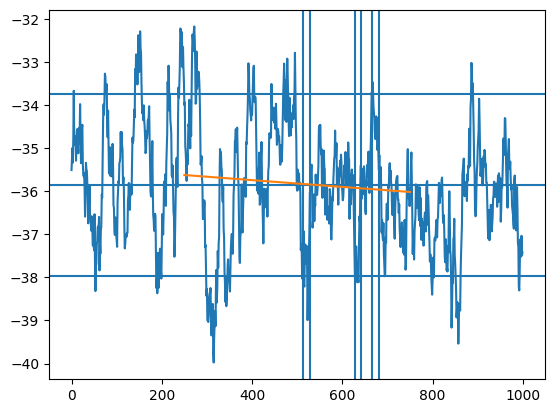

In [23]:
pair = ("24", "49")
beta = [1, -1.76]
deltaFull = beta[0] * df[pair[0]] + beta[1] * df[pair[1]]
deltaTrain = beta[0] * df[pair[0]] + beta[1] * df[pair[1]]
deltaFull = list(deltaFull)
sns.lineplot(deltaFull)

plt.axvline(x = 529)
plt.axvline(x = 641)
plt.axvline(x = 682)
plt.axvline(x = 512)
plt.axvline(x = 629)
plt.axvline(x = 666)

plt.axhline(y=np.mean(deltaTrain))
off = 1.5
plt.axhline(y=np.mean(deltaTrain) + 1.5 * np.std(deltaTrain))
plt.axhline(y=np.mean(deltaTrain) - 1.5 * np.std(deltaTrain))

x = np.array(range(250,751))
y = np.array(deltaFull[250:751])
m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b)

print(m, b)
test_stationary(deltaFull, printing=True)

In [19]:
print(np.mean(deltaTrain))
print(np.mean(deltaFull))
print(np.std(deltaTrain))
print(np.std(deltaTrain) * (1.5 + 1/3))

-35.8631276
-35.8631276
1.4104603201076735
2.5858439201974015


In [18]:
pair=(20, 35)
result = engle_granger(train[str(pair[0])], train[str(pair[1])], trend='c', method='bic')
testTest = engle_granger(test[str(pair[0])], test[str(pair[1])], trend='c', method='bic')
print(result)
print(testTest)
print(engle_granger(df[str(pair[0])], df[str(pair[1])], trend='c', method='bic'))
print(result.cointegrating_vector)

Engle-Granger Cointegration Test
Statistic: -3.0341061817401007
P-value: 0.10294455600852964
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 0
Trend: c
Estimated Root ρ (γ+1): 0.965759928407014
Distribution Order: 1
Engle-Granger Cointegration Test
Statistic: -2.5827809962839225
P-value: 0.2442245596610002
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 0
Trend: c
Estimated Root ρ (γ+1): 0.9497967003458468
Distribution Order: 1
Engle-Granger Cointegration Test
Statistic: -3.7748827706680537
P-value: 0.014860954970487342
Null: No Cointegration, Alternative: Cointegration
ADF Lag length: 0
Trend: c
Estimated Root ρ (γ+1): 0.9642195885563426
Distribution Order: 1
20       1.000000
35      -0.532902
const   -1.929980
dtype: float64


In [10]:
# Check how the coeff changes for full dataset
check = engle_granger(test["28"], test["49"], trend="c", method="bic")
print(check.cointegrating_vector)
check

28       1.000000
49      -0.469086
const   -2.041485
dtype: float64


Test Statistic,-3.519
P-value,0.031
ADF Lag length,0
Estimated Root ρ (γ+1),0.904


C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\2123200811.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")


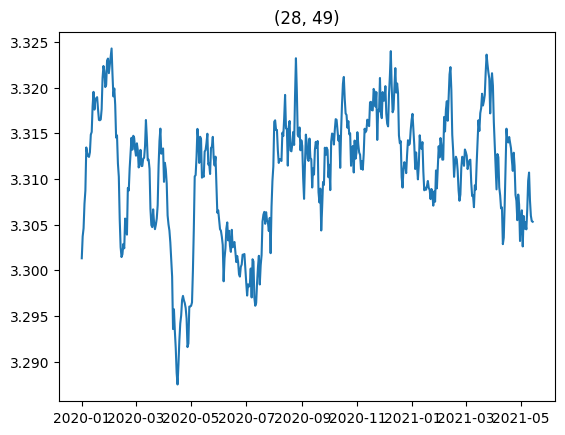

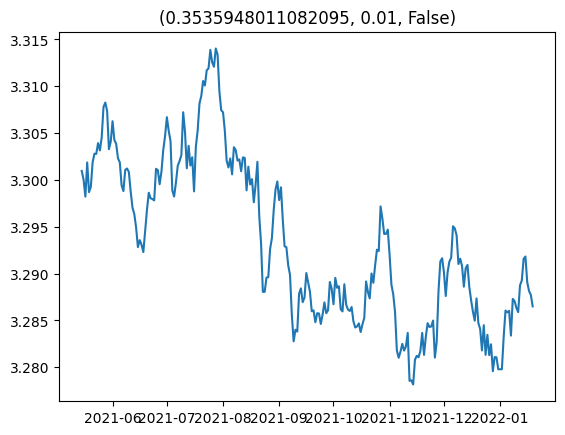

In [11]:
# Test previous pair in last submission - Doesn't fit at all
pairs = [(28, 49)]
betas = [[1.000000, -0.154962]]

# pairs = [(i, j) for i in range(50) for j in range(i+1, 50)]
# betas = [(1, -1) for i in range(len(pairs))]
for i in range(len(pairs)):
    pair = pairs[i]
    # print(pair)
    # print(coint_vecs[pair])
    # beta = coint_vecs[pair].values
    beta = betas[i]
    residualTrain = beta[0] * train[str(pair[0])] + beta[1] * train[str(pair[1])]
    residualTest = beta[0] * test[str(pair[0])] + beta[1] * test[str(pair[1])]
    # if test_stationary(residualTrain, printing=False)[2] and test_stationary(residualTest, printing=False)[2]:
    plt.figure()
    plt.title(pair)
    plt.plot(residualTrain)
    plt.figure()
    plt.title(test_stationary(residualTest, printing=False))
    plt.plot(residualTest)

In [12]:
# Test group to form stationary
# With both the train and test, no combinations found (lib might not be good though)
def get_johansen(y, p):
    """
    Get the cointegration vectors at 95% level of significance
    given by the trace statistic test.
    """

    N, l = y.shape
    jres = coint_johansen(y, 0, p)
    trstat = jres.lr1                       # trace statistic
    tsignf = jres.cvt                       # critical values

    if N > 12:
        jres.r = l
        jres.evecr = jres.evec
        return jres

    for i in range(l):
        if trstat[i] > tsignf[i, 1]:     # 0: 90%  1:95% 2: 99%
            r = i + 1
    jres.r = r
    jres.evecr = jres.evec[:, :r]

    return jres


In [13]:
p=1
jres=get_johansen(train[["14", "18"]], p)
print("There are ", jres.r, "cointegration vectors")
all_vecs = []
for i in range(jres.r):
    all_vecs.append(jres.evecr[:,i])
    print(all_vecs[i])

There are  2 cointegration vectors
[ 28.23546001 -19.33043185]
[-5.34357357 23.51717568]


In [14]:
p=1
jres=get_johansen(train,p)
print("There are ", jres.r, "cointegration vectors")
all_vecs = []
for i in range(jres.r):
    all_vecs.append(jres.evecr[:,i])
    print(all_vecs[i])

There are  50 cointegration vectors
[   6.97264337  -36.44103534   43.23932085   -0.53116149  -41.18191915
  -19.9941564   -24.01381641    3.84955234   86.69946801  -13.19094109
  -26.83044675  -16.89583114   42.48763293  -25.36272203    1.58188305
    4.6525782  -106.28495022  -44.11925269   64.5295618    14.69630651
    1.32576184   19.16403478   15.31193061   41.4660613   -63.78554948
   -9.57363508   19.10076005  153.06981934 -141.02634159 -111.36947836
   -5.96757797   18.81723947  -43.92813251  -57.69841975  -31.74885144
  -23.98472246    9.64597409    2.78499236  433.59456257  235.51573058
  -53.1072654   -15.1758142    15.78478785   13.12716637   24.48796708
 -134.75155206    6.30555405  -51.98864204  -21.71765801  -14.08213583]
[  23.6742187     5.05094995   25.49171896   -3.01959402   15.64226818
   -8.90621614  110.58595505   -7.32441369  -61.17949043   31.50444248
   16.22687433   23.69392282   18.04691945  -22.13617477   23.09016396
   34.80247715 -232.28193127   61.982278

C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\3669680207.py:10: HypothesisTestWarning: Critical values are only available for time series with 12 variables at most.
  jres = coint_johansen(y, 0, p)


C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\2123200811.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\2123200811.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\2123200811.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = stattools.kpss(series, regression="c", nlags="auto")
C:\Users\DELL\AppData\Local\Temp\ipykernel_11120\2123200811.py:21: InterpolationWarning: The test st

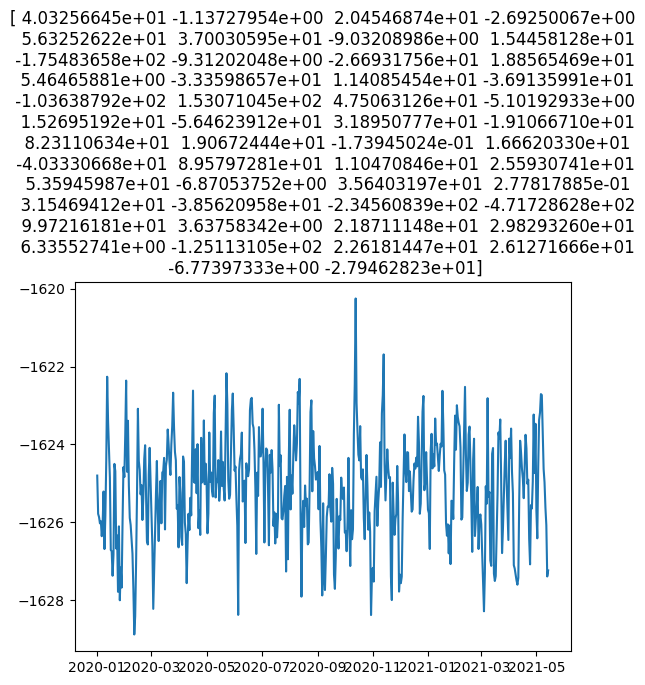

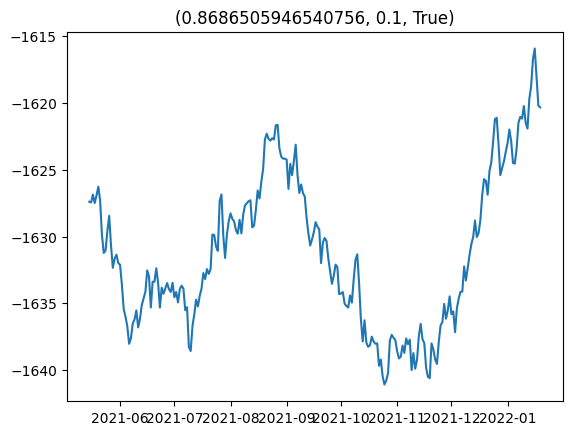

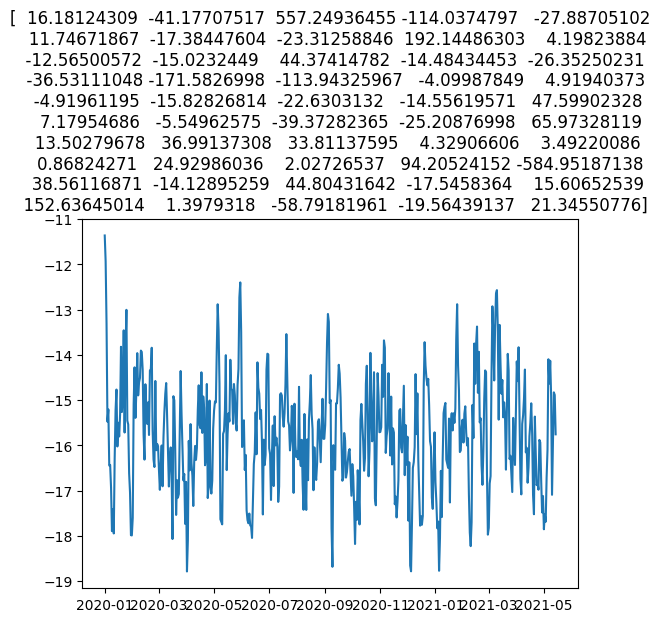

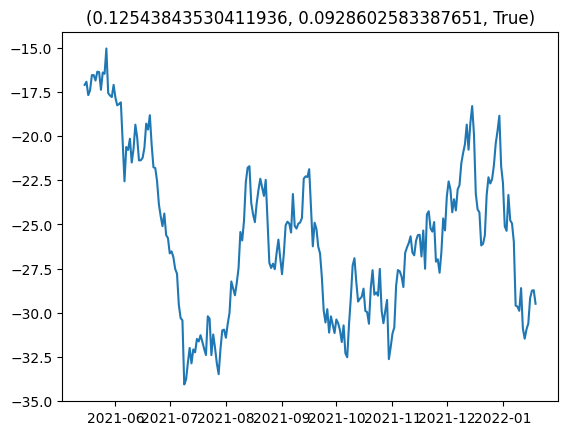

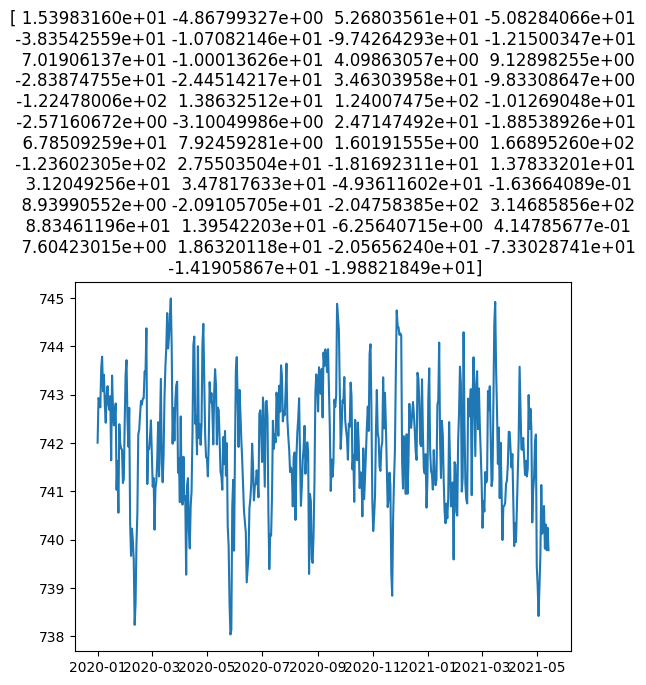

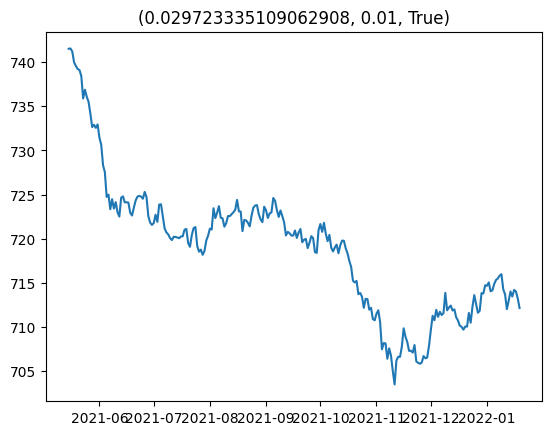

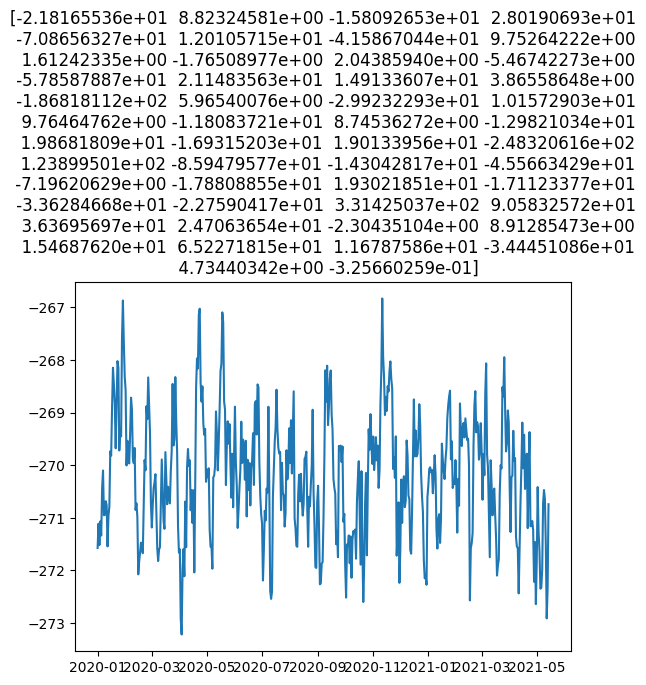

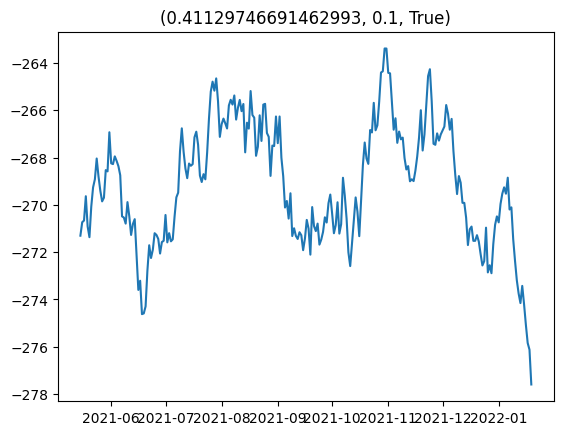

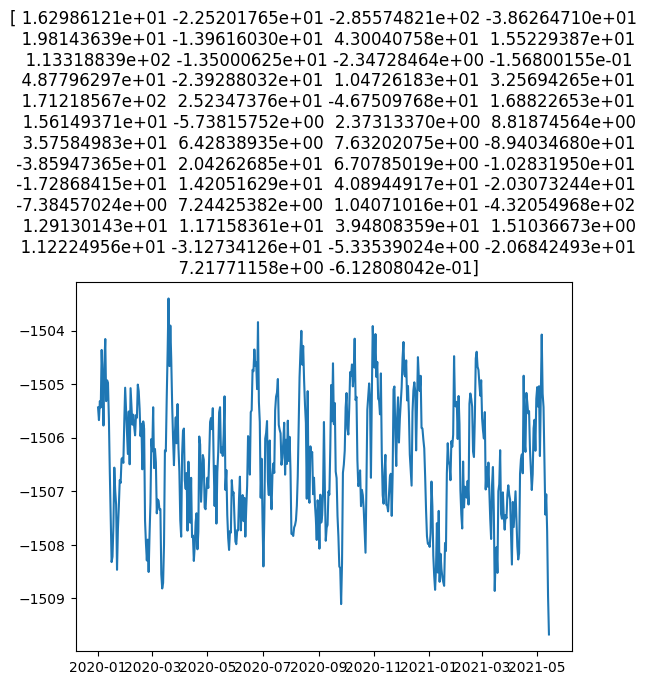

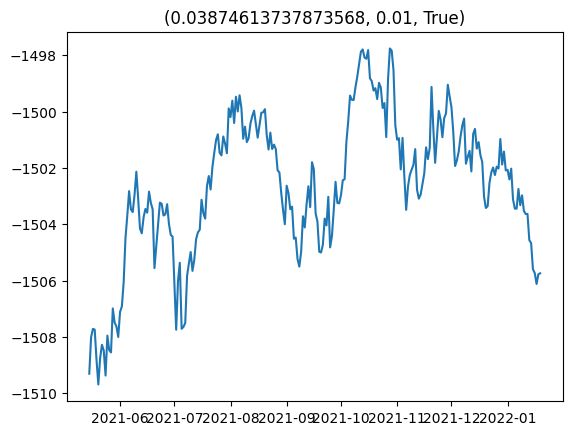

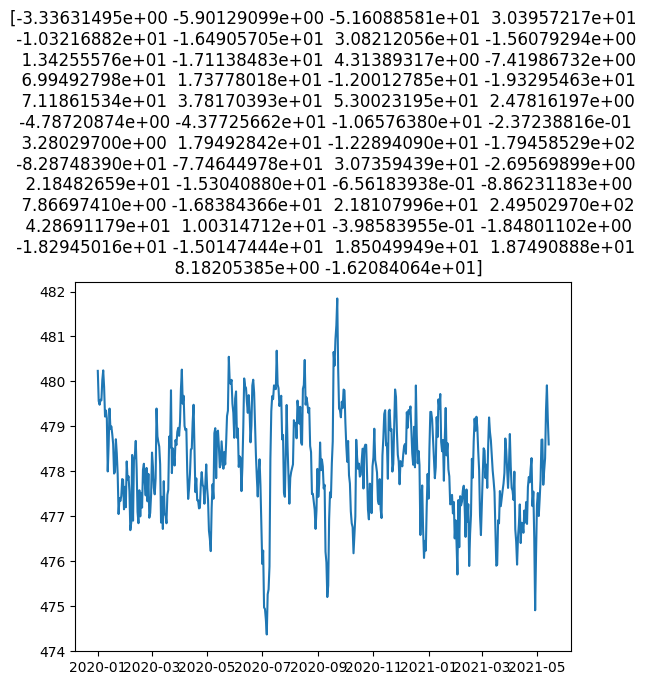

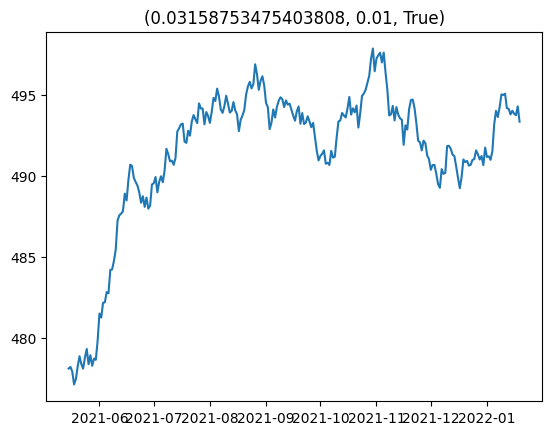

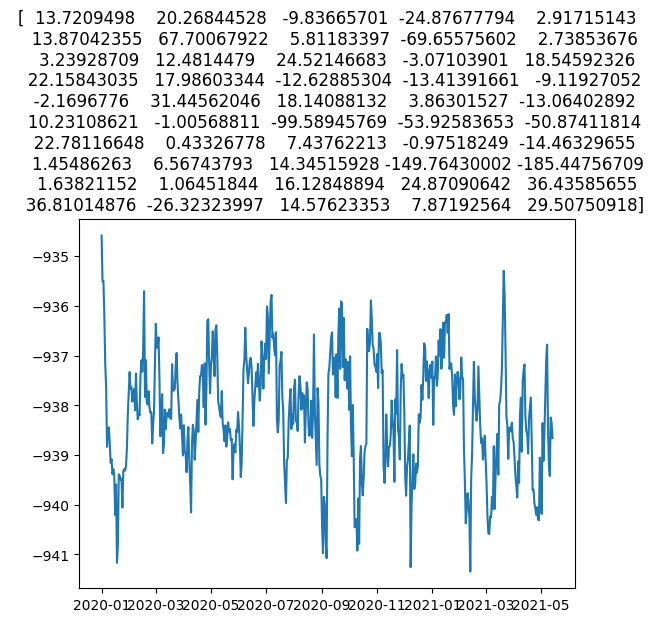

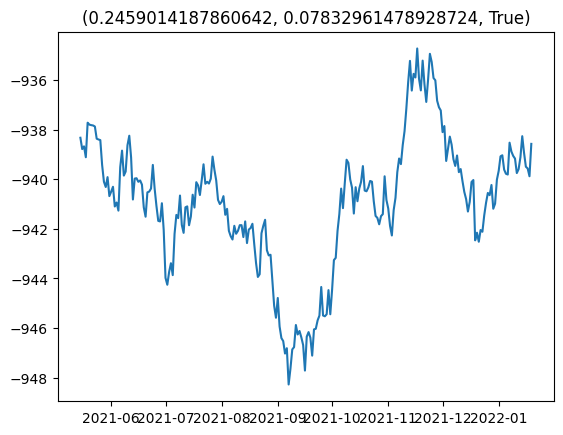

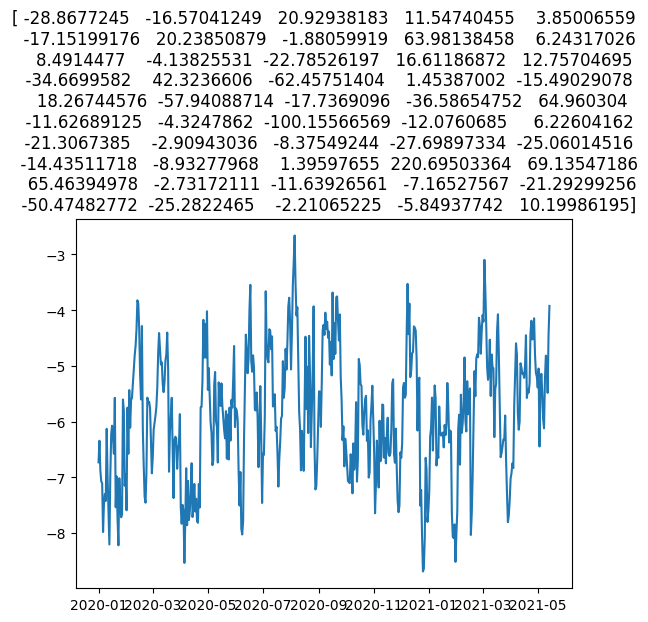

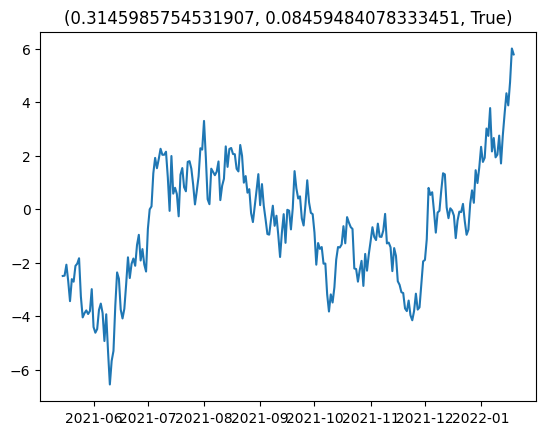

In [15]:
for betas in all_vecs:
    residualTrain = 0
    residualTest = 0
    for i in range(len(betas)):
        residualTrain += betas[i] * train[str(i)]
        residualTest += betas[i] * test[str(i)]
    
    if test_stationary(residualTrain, printing=False)[2] and test_stationary(residualTest, printing=False)[2]:
        plt.figure()
        plt.title(str(betas))
        plt.plot(residualTrain)
        plt.figure()
        plt.title(test_stationary(residualTest, printing=False))
        plt.plot(residualTest)